In [54]:
import json
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from constants import DATA_DIR
from scipy import stats
from sklearn.model_selection import KFold, train_test_split
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sns.set_theme()

In [2]:
FEATURES_DIR = DATA_DIR / "features"

In [3]:
feature_files = [file for file in FEATURES_DIR.iterdir() if file.suffix == ".json"]
len(feature_files)

192

In [4]:
class AsteroidData(TypedDict):
    is_failed: bool
    reason: str | None
    period: float
    processing_time: float
    features: np.ndarray

In [5]:
class AsteroidDataset(Dataset):
    def __init__(self, data: np.ndarray, targets: np.ndarray):
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [6]:
def create_dataloaders(X, y, batch_size=32, shuffle=True) -> DataLoader:
    dataset = AsteroidDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [7]:
class AsteroidPeriodPredictor(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(AsteroidPeriodPredictor, self).__init__()
        
        # Convolutional layers to capture local patterns
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
        )
        
        # LSTM to capture sequential dependencies
        self.lstm = nn.LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)
        
        # Fully connected layers for final prediction
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, 50, 2)
        batch_size, seq_len, _ = x.shape
        
        # Reshape for conv layers (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        
        x = self.conv_layers(x)  # Shape: (batch_size, 64, 50)
        
        # Reshape for LSTM (batch_size, seq_len, features)
        x = x.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, 50, 256)
        
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        pooled = torch.mean(attn_out, dim=1)  # Shape: (batch_size, 256)
        
        out = self.fc(pooled)
        
        return out.squeeze(-1)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def custom_loss(pred, target, input_freqs):
    mse_loss = F.mse_loss(pred, target)
    closest_freq_loss = torch.min(torch.abs(pred.unsqueeze(1) - input_freqs), dim=1)[0]
    return mse_loss + 0.1 * closest_freq_loss.mean()

In [10]:
def train_model(model, train_loader, val_loader, epochs=1000, patience=25, verbose: bool = True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=20)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            mse_loss = criterion(outputs, targets)
            custom_loss_value = custom_loss(outputs, targets, data[:, :, 0])
            loss = mse_loss + custom_loss_value
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        train_r2 = stats.pearsonr(train_targets, train_preds)[0] ** 2
        train_mae = np.mean(np.abs(np.array(train_targets) - np.array(train_preds)))

        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                mse_loss = criterion(outputs, targets)
                custom_loss_value = custom_loss(outputs, targets, data[:, :, 0])
                loss = mse_loss + custom_loss_value
                val_loss += loss.item()
                val_preds.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        val_loss /= len(val_loader)
        val_r2 = stats.pearsonr(val_targets, val_preds)[0] ** 2
        val_mae = np.mean(np.abs(np.array(val_targets) - np.array(val_preds)))

        scheduler.step(val_loss)

        if verbose:
            print(f"{epoch + 1:3}/{epochs} - ", end="")
            print(f"Train-loss: {train_loss:.4f}, Train-R2: {train_r2:.4f}, Train-MAE: {train_mae:.4f}", end="\t- ")
            print(f"Val-loss: {val_loss:.4f}, Val-R2: {val_r2:.4f}, Val-MAE: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            if verbose:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

    if verbose:
        print(f"Best validation loss: {best_val_loss}")

    return best_val_loss

In [11]:
with open(feature_files[0], "r") as file:
    data = json.load(file)

config, asteroids_data = data["config"], data["asteroids"]

periods = [data["period"] for data in asteroids_data.values() if not data["is_failed"]]
print(f"Percentiles: {np.percentile(periods, [0, 5, 25, 50, 75, 85, 95, 100]).tolist()}")

max_period = 45
satisfying_asteroids = [data for data in asteroids_data.values() if not data["is_failed"] and data["period"] <= max_period]
print(
    f"If we cut-off asteroids with max period={max_period} we will have {len(satisfying_asteroids)} ({len(satisfying_asteroids) / len(periods):.4f}%) asteroids"
)

Percentiles: [2.39006, 3.60404535, 5.89389175, 8.8234, 14.8299, 20.07371, 67.52574499999997, 771.1]
If we cut-off asteroids with max period=45 we will have 764 (0.9317%) asteroids


In [12]:
MAX_PERIOD = 45
VERBOSE = False


def process_dataset(feature_file):
    with open(feature_file, "r") as f:
        loaded_data = json.load(f)

    config, asteroids_data = loaded_data["config"], loaded_data["asteroids"]

    filtered_data = {
        name: AsteroidData(**data)
        for name, data in asteroids_data.items()
        if not data["is_failed"] and data["period"] <= MAX_PERIOD
    }

    clipped_data = []
    periods = []
    for asteroid_name, data in filtered_data.items():
        arr = np.array(data["features"])

        idx = np.argsort(arr[:, :, 1].flatten())[::-1][:50]
        seq_idx, row_idx = np.unravel_index(idx, arr[:, :, 1].shape)

        clipped_data.append(arr[seq_idx, row_idx])
        periods.append(data["period"])

    clipped_data = np.array(clipped_data)
    periods = np.array(periods)

    # Convert periods to frequencies
    frequencies = 24 / periods

    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(clipped_data)):
        if VERBOSE:
            print(f"Fold {fold+1}/{n_splits}")

        X_train, X_val = clipped_data[train_idx], clipped_data[val_idx]
        y_train, y_val = frequencies[train_idx], frequencies[val_idx]

        # Frequencies are always between 0 and 12 (data - min) / (max - min)
        X_train_normalized = X_train.copy()
        X_train_normalized[:, :, 0] /= 12

        X_val_normalized = X_val.copy()
        X_val_normalized[:, :, 0] /= 12

        y_train_normalized = y_train / 12
        y_val_normalized = y_val / 12

        train_loader = create_dataloaders(X_train_normalized, y_train_normalized)
        val_loader = create_dataloaders(X_val_normalized, y_val_normalized, shuffle=False)

        model = AsteroidPeriodPredictor().to(device)

        best_val_loss = train_model(model, train_loader, val_loader, epochs=200, patience=25, verbose=VERBOSE)

        fold_results.append(best_val_loss)

    dataset_result = {
        "min_loss": np.min(fold_results),
        "max_loss": np.max(fold_results),
        "mean_loss": np.mean(fold_results),
        "std_loss": np.std(fold_results),
        "median_loss": np.median(fold_results),
        "fold_results": fold_results,
    }

    if VERBOSE:
        print("-----------")
        print(f"Min validation loss: {dataset_result['min_loss']}")
        print(f"Max validation loss: {dataset_result['max_loss']}")
        print(f"Average validation loss: {dataset_result['mean_loss']}")
        print(f"Standard deviation: {dataset_result['std_loss']}")

    return dataset_result

In [13]:
dataset_results = []
for ind, feature_file in enumerate(tqdm(feature_files)):
    dataset_result = process_dataset(feature_file)
    dataset_result["config_no"] = ind + 1
    dataset_results.append(dataset_result)

 32%|███▏      | 61/192 [36:20<1:09:04, 31.64s/it]/tmp/ipykernel_25010/2570043573.py:50: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  val_r2 = stats.pearsonr(val_targets, val_preds)[0] ** 2
 84%|████████▍ | 162/192 [1:29:22<24:20, 48.70s/it]/tmp/ipykernel_25010/2570043573.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_r2 = stats.pearsonr(val_targets, val_preds)[0] ** 2
100%|██████████| 192/192 [1:47:28<00:00, 33.59s/it]


In [46]:
def compare_datasets(dataset_results, top_n=5, verbose: bool = True):
    sorted_datasets = sorted(dataset_results, key=lambda x: x["mean_loss"])

    top_n_datasets = sorted_datasets[:top_n]

    if verbose:
        print(f"Top {top_n} datasets:")
        for i, dataset in enumerate(top_n_datasets):
            print(f"Rank {i+1}: Dataset {dataset['config_no']}")
            print(f"  Mean Loss: {dataset['mean_loss']:.4f}")
            print(f"  Std Dev: {dataset['std_loss']:.4f}")
            print(f"  Median Loss: {dataset['median_loss']:.4f}")
            print(f"  Min Loss: {dataset['min_loss']:.4f}")
            print(f"  Max Loss: {dataset['max_loss']:.4f}")
            print()

    return top_n_datasets

In [63]:
with open(DATA_DIR / "dataset_results.json", "w") as file:
    json.dump(dataset_results, file, indent=4)

In [47]:
best_datasets = compare_datasets(dataset_results)
print(f"The best performing dataset is Dataset {best_datasets[0]['config_no']}")

Top 5 datasets:
Rank 1: Dataset 45
  Mean Loss: 0.0231
  Std Dev: 0.0232
  Median Loss: 0.0145
  Min Loss: 0.0065
  Max Loss: 0.0691

Rank 2: Dataset 37
  Mean Loss: 0.0250
  Std Dev: 0.0167
  Median Loss: 0.0188
  Min Loss: 0.0077
  Max Loss: 0.0491

Rank 3: Dataset 34
  Mean Loss: 0.0257
  Std Dev: 0.0181
  Median Loss: 0.0235
  Min Loss: 0.0085
  Max Loss: 0.0577

Rank 4: Dataset 25
  Mean Loss: 0.0259
  Std Dev: 0.0166
  Median Loss: 0.0175
  Min Loss: 0.0052
  Max Loss: 0.0490

Rank 5: Dataset 43
  Mean Loss: 0.0274
  Std Dev: 0.0160
  Median Loss: 0.0362
  Min Loss: 0.0072
  Max Loss: 0.0465

The best performing dataset is Dataset 45


In [37]:
def visualize_results(dataset_results, num_top_datasets=20):
    # Convert results to a DataFrame for easier plotting
    df = pd.DataFrame(dataset_results)
    df = df.sort_values("mean_loss").reset_index(drop=True)
    top_df = df.head(num_top_datasets)

    # Box plot of validation losses for top datasets
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=top_df["fold_results"].tolist(), orient="h")
    plt.title(f"Distribution of Validation Losses for Top {num_top_datasets} Datasets")
    plt.xlabel("Validation Loss")
    plt.ylabel("Dataset Rank")
    plt.tight_layout()
    plt.show()

    # Scatter plot of mean loss vs std dev for all datasets
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x="mean_loss", y="std_loss", hue="config_no", palette="viridis", legend=False)
    plt.title("Mean Validation Loss vs Standard Deviation (All Datasets)")
    plt.xlabel("Mean Validation Loss")
    plt.ylabel("Standard Deviation of Validation Loss")
    plt.tight_layout()
    plt.show()

    # Bar plot of mean losses for top datasets
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(data=top_df, x="config_no", y="mean_loss", hue="config_no", dodge=False, legend=False)
    plt.title(f"Mean Validation Loss for Top {num_top_datasets} Datasets")
    plt.xlabel("Config Number")
    plt.ylabel("Mean Validation Loss")
    plt.xticks(rotation=45)
    # Add value labels on the bars
    for i, v in enumerate(top_df["mean_loss"]):
        ax.text(i, v, f"{v:.4f}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

    # Violin plot for top datasets
    plt.figure(figsize=(16, 8))
    violin_data = pd.DataFrame(
        {"Config": np.repeat(top_df["config_no"], 5), "Validation Loss": np.concatenate(top_df["fold_results"].tolist())}
    )
    sns.violinplot(data=violin_data, x="Config", y="Validation Loss", hue="Config", legend=False)
    plt.title(f"Distribution of Validation Losses for Top {num_top_datasets} Datasets")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Histogram of mean losses for all datasets
    plt.figure(figsize=(16, 8))
    sns.histplot(data=df, x="mean_loss", bins=30, kde=True)
    plt.title("Distribution of Mean Validation Losses (All Datasets)")
    plt.xlabel("Mean Validation Loss")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Cumulative distribution plot of mean losses
    plt.figure(figsize=(16, 8))
    sns.ecdfplot(data=df, x="mean_loss")
    plt.title("Cumulative Distribution of Mean Validation Losses (All Datasets)")
    plt.xlabel("Mean Validation Loss")
    plt.ylabel("Cumulative Proportion")
    plt.tight_layout()
    plt.show()

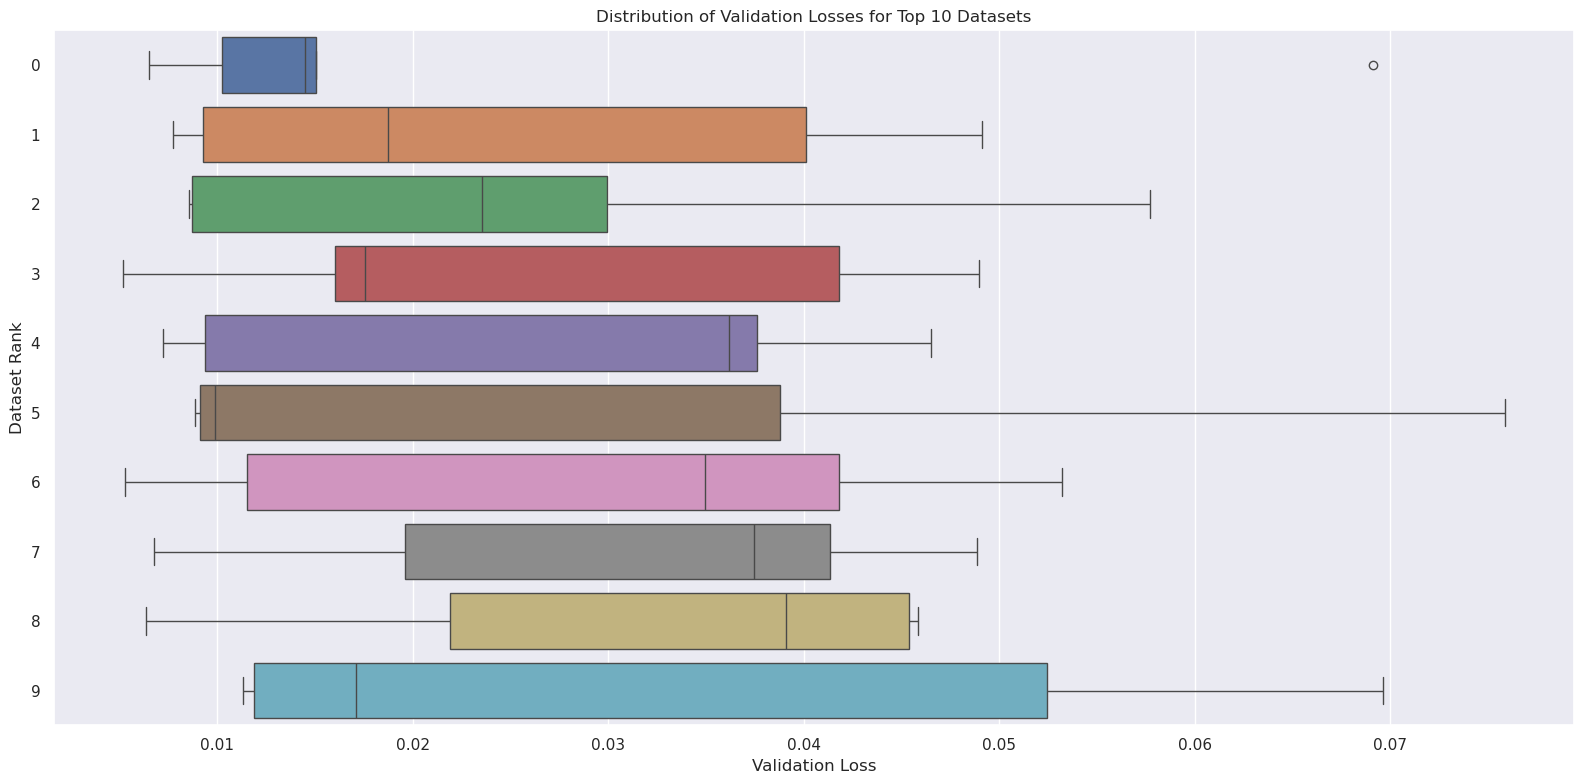

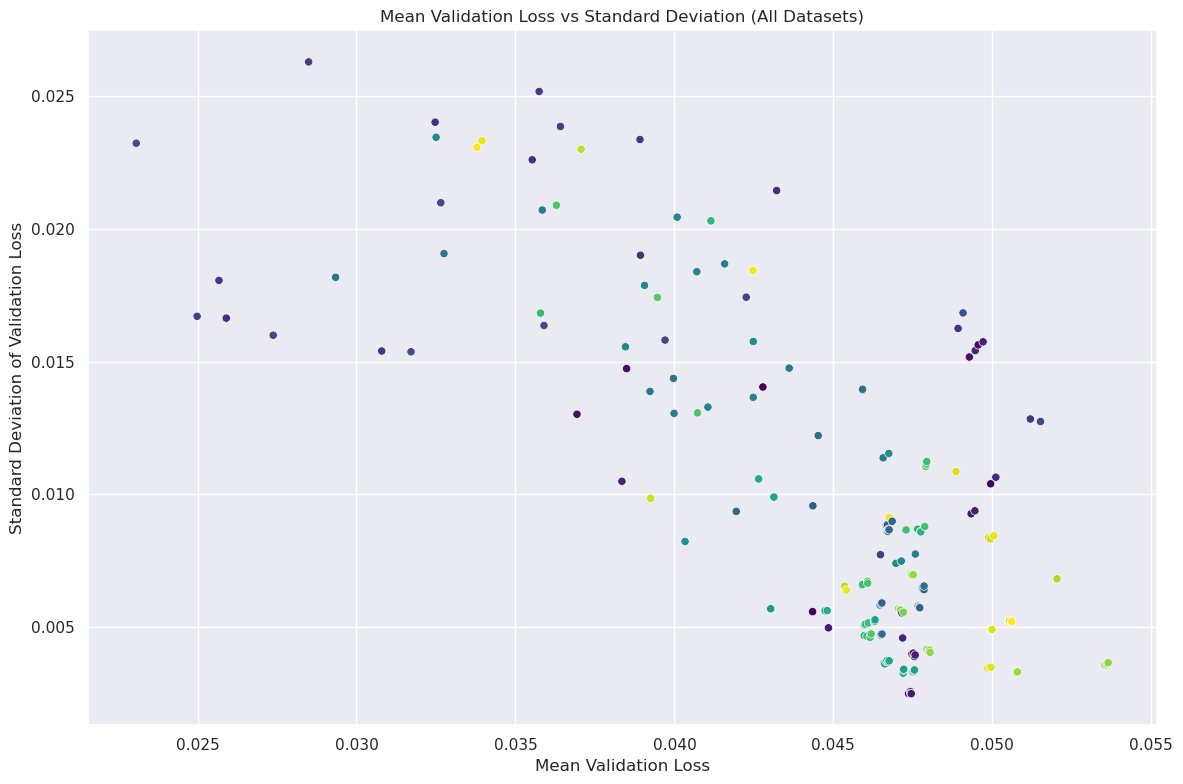

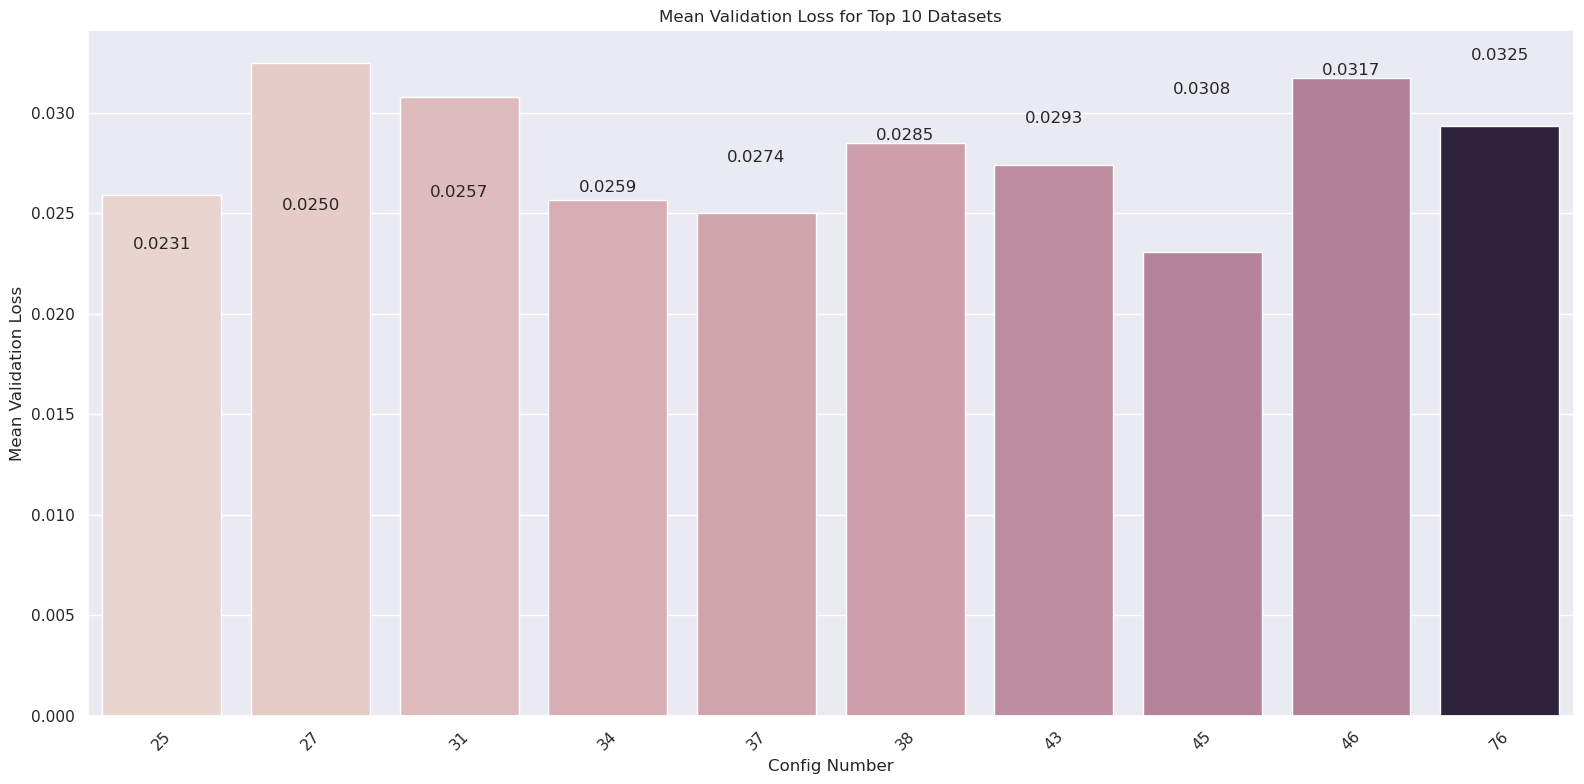

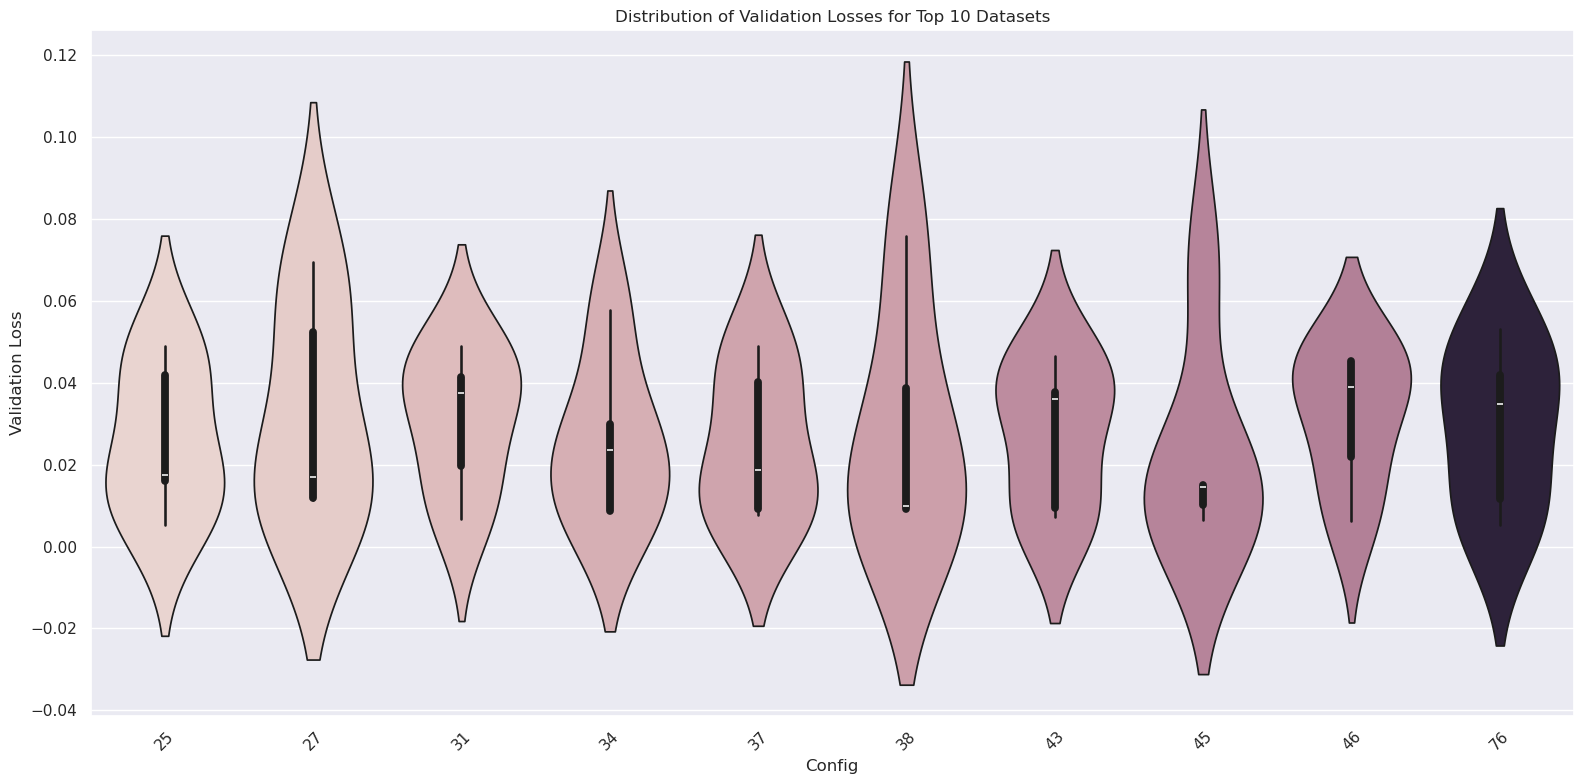

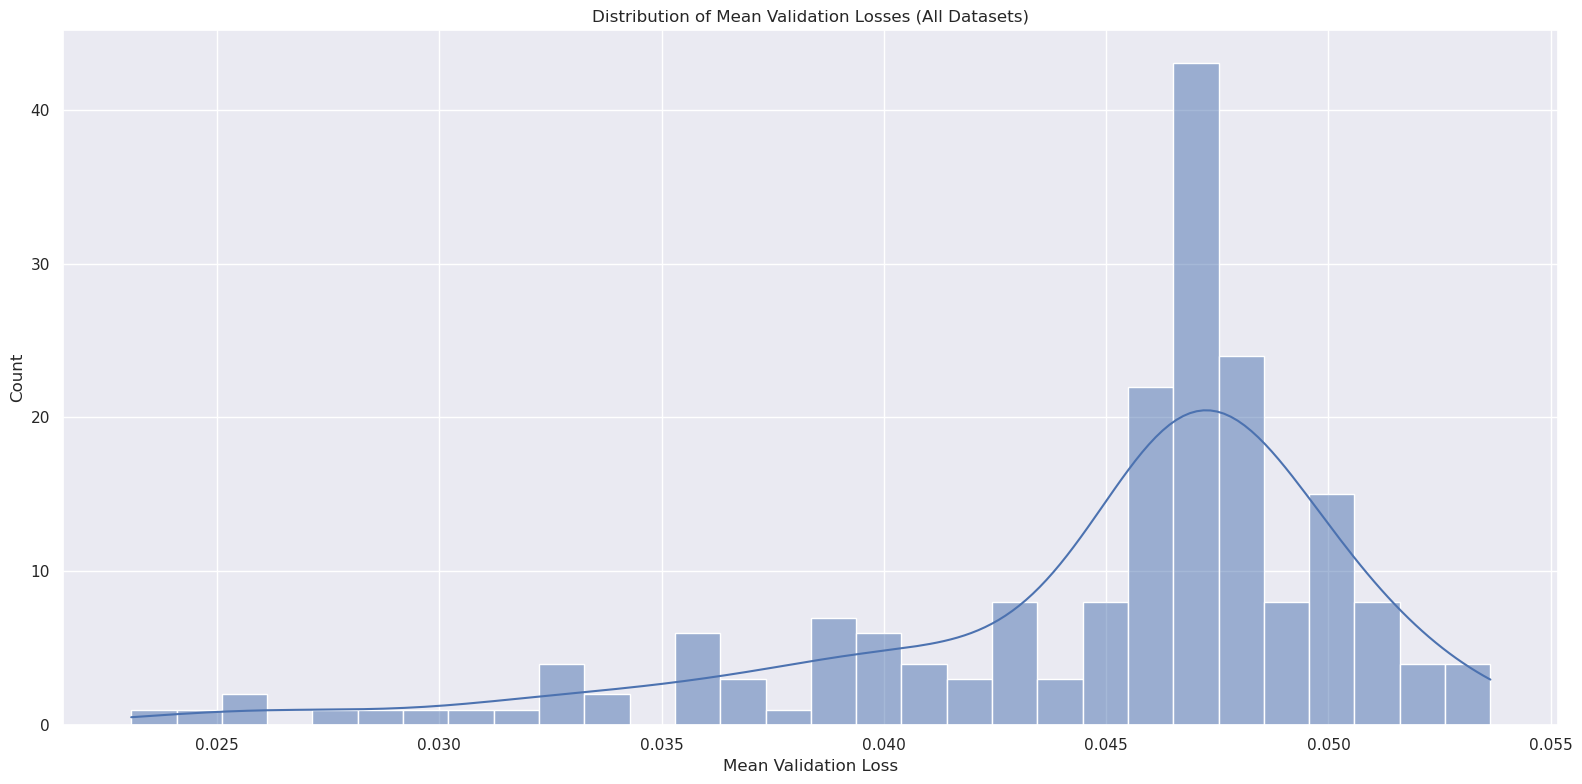

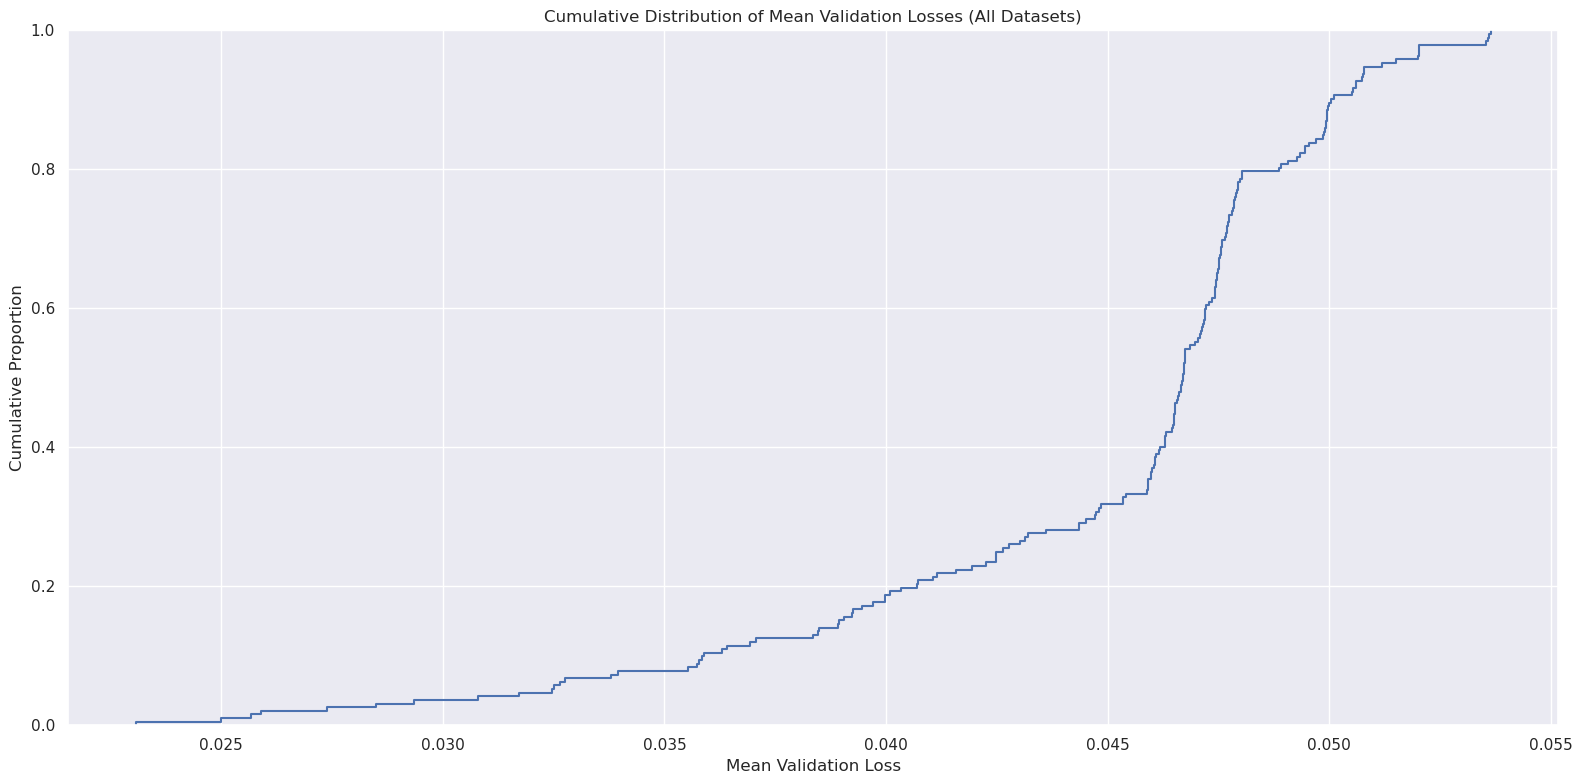

In [38]:
visualize_results(dataset_results, num_top_datasets=10)

In [55]:
def process_and_split_dataset(feature_file, test_size=0.05):
    with open(feature_file, "r") as f:
        loaded_data = json.load(f)

    config, asteroids_data = loaded_data["config"], loaded_data["asteroids"]

    filtered_data = {
        name: AsteroidData(**data)
        for name, data in asteroids_data.items()
        if not data["is_failed"] and data["period"] <= MAX_PERIOD
    }

    clipped_data = []
    periods = []
    for asteroid_name, data in filtered_data.items():
        arr = np.array(data["features"])
        idx = np.argsort(arr[:, :, 1].flatten())[::-1][:50]
        seq_idx, row_idx = np.unravel_index(idx, arr[:, :, 1].shape)
        clipped_data.append(arr[seq_idx, row_idx])
        periods.append(data["period"])

    clipped_data = np.array(clipped_data)
    periods = np.array(periods)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(clipped_data, periods, test_size=test_size, random_state=88688)

    return X_train, X_test, y_train, y_test, config


def train_model_without_validation(model, train_loader, epochs=200, patience=25, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=1e-6)

    best_train_loss = float("inf")
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            mse_loss = criterion(outputs, targets)
            custom_loss_value = custom_loss(outputs, targets, data[:, :, 0])
            loss = mse_loss + custom_loss_value
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        train_r2 = stats.pearsonr(train_targets, train_preds)[0] ** 2
        train_mae = np.mean(np.abs(np.array(train_targets) - np.array(train_preds)))

        scheduler.step()

        if verbose:
            print(f"{epoch + 1:3}/{epochs} - ", end="")
            print(f"Train-loss: {train_loss:.4f}, Train-R2: {train_r2:.4f}, Train-MAE: {train_mae:.4f}")

        if train_loss < best_train_loss:
            best_train_loss = train_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            if verbose:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

    if verbose:
        print(f"Best training loss: {best_train_loss}")

    model.load_state_dict(best_model_state)
    return model, best_train_loss

def train_and_predict(X_train, y_train, X_test):
    # Convert periods to frequencies
    frequencies_train = 24 / y_train

    # Normalize the data
    X_train_normalized = X_train.copy()
    X_train_normalized[:, :, 0] /= 12
    y_train_normalized = frequencies_train / 12

    X_test_normalized = X_test.copy()
    X_test_normalized[:, :, 0] /= 12

    # Create data loader
    train_loader = create_dataloaders(X_train_normalized, y_train_normalized)

    # Train the model
    model = AsteroidPeriodPredictor().to(device)
    model, best_loss = train_model_without_validation(model, train_loader, epochs=1000, patience=25, verbose=True)

    # Make predictions on test data
    model.eval()
    test_loader = create_dataloaders(X_test_normalized, np.zeros(len(X_test)), shuffle=False)
    
    predictions = []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            outputs = model(data)
            predictions.extend(outputs.cpu().numpy())
    
    # Denormalize predictions
    predictions = np.array(predictions) * 12
    periods_pred = 24 / predictions

    return periods_pred, best_loss

In [56]:
top_datasets = compare_datasets(dataset_results, top_n=5, verbose=False)

top_dataset_files = [feature_files[dataset["config_no"] - 1] for dataset in top_datasets]
top_dataset_files

[PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_45.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_37.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_34.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_25.json'),
 PosixPath('/home/marek/Projects/asteroid-lightcurves/data/features/asteroids_freq_data_43.json')]

In [57]:
all_predictions = []
true_periods = []
for feature_file in top_dataset_files:
    X_train, X_test, y_train, y_test, config = process_and_split_dataset(feature_file)
    periods_pred, _ = train_and_predict(X_train, y_train, X_test)
    all_predictions.append(periods_pred)
    true_periods.append(y_test)

  1/1000 - Train-loss: 0.1331, Train-R2: 0.0000, Train-MAE: 0.1999
  2/1000 - Train-loss: 0.0643, Train-R2: 0.0000, Train-MAE: 0.1354
  3/1000 - Train-loss: 0.0634, Train-R2: 0.0014, Train-MAE: 0.1356
  4/1000 - Train-loss: 0.0576, Train-R2: 0.0009, Train-MAE: 0.1290
  5/1000 - Train-loss: 0.0575, Train-R2: 0.0000, Train-MAE: 0.1277
  6/1000 - Train-loss: 0.0590, Train-R2: 0.0009, Train-MAE: 0.1339
  7/1000 - Train-loss: 0.0568, Train-R2: 0.0006, Train-MAE: 0.1269
  8/1000 - Train-loss: 0.0581, Train-R2: 0.0023, Train-MAE: 0.1307
  9/1000 - Train-loss: 0.0598, Train-R2: 0.0044, Train-MAE: 0.1322
 10/1000 - Train-loss: 0.0550, Train-R2: 0.0000, Train-MAE: 0.1283
 11/1000 - Train-loss: 0.0583, Train-R2: 0.0003, Train-MAE: 0.1256
 12/1000 - Train-loss: 0.0569, Train-R2: 0.0004, Train-MAE: 0.1259
 13/1000 - Train-loss: 0.0539, Train-R2: 0.0011, Train-MAE: 0.1255
 14/1000 - Train-loss: 0.0543, Train-R2: 0.0009, Train-MAE: 0.1243
 15/1000 - Train-loss: 0.0531, Train-R2: 0.0001, Train-MAE: 0.

In [59]:
predictions_df = pd.DataFrame(np.array(all_predictions).T, columns=[f"Config {d['config_no']}" for d in top_datasets])

# Add true periods to the DataFrame
predictions_df["True_Period"] = true_periods[0]  # Assuming all test sets have the same true periods

predictions_df

,Config 45,Config 37,Config 34,Config 25,Config 43,True_Period
0,8.301690,10.383552,16.095440,7.495492,7.346912,8.104280
1,16.299522,13.795064,4.261805,7.495492,7.346912,31.462500
2,16.254128,14.422072,12.127081,7.495492,7.346912,16.780900
3,5.125740,6.622957,12.576278,7.495492,7.346912,3.854798
4,16.405542,8.773131,9.009728,7.495492,7.346912,27.070300
5,15.958465,14.203159,15.263493,7.495492,7.346912,16.103120
6,9.518452,12.439960,5.992673,7.495492,7.346912,9.375090
7,8.115369,14.169395,10.502062,7.495492,7.346912,5.750249
8,15.556344,12.168193,15.453261,7.495492,7.346912,8.180050
9,15.766304,13.586894,15.852180,7.495492,7.346912,13.687170
